# Draft/Incomplete

I am still working on this notebook, but posting it as a way to share my work.

## Import modules

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

## Check Data

In [2]:
df = pd.read_csv('../data/processed/cmbd.csv')
df.head()

,Unnamed: 0,age,Medu,Fedu,traveltime,studytime,failures,schoolsup,famsup,paid,...,Fjob_other,Fjob_services,Fjob_teacher,reason_course,reason_home,reason_other,reason_reputation,guardian_father,guardian_mother,guardian_other
0,0,18,4,4,2,2,0,1,0,0,...,0,0,1,1,0,0,0,0,1,0
1,1,17,1,1,1,2,0,0,1,0,...,1,0,0,1,0,0,0,1,0,0
2,2,15,1,1,1,2,0,1,0,0,...,1,0,0,0,0,1,0,0,1,0
3,3,15,4,2,1,3,0,0,1,0,...,0,1,0,0,1,0,0,0,1,0
4,4,16,3,3,1,2,0,0,1,0,...,1,0,0,0,1,0,0,1,0,0


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 649 entries, 0 to 648
Data columns (total 52 columns):
 #   Column             Non-Null Count  Dtype
---  ------             --------------  -----
 0   Unnamed: 0         649 non-null    int64
 1   age                649 non-null    int64
 2   Medu               649 non-null    int64
 3   Fedu               649 non-null    int64
 4   traveltime         649 non-null    int64
 5   studytime          649 non-null    int64
 6   failures           649 non-null    int64
 7   schoolsup          649 non-null    int64
 8   famsup             649 non-null    int64
 9   paid               649 non-null    int64
 10  activities         649 non-null    int64
 11  nursery            649 non-null    int64
 12  higher             649 non-null    int64
 13  internet           649 non-null    int64
 14  romantic           649 non-null    int64
 15  famrel             649 non-null    int64
 16  freetime           649 non-null    int64
 17  goout           

In [4]:
df['G3'].describe()

count    649.000000
mean      11.906009
std        3.230656
min        0.000000
25%       10.000000
50%       12.000000
75%       14.000000
max       19.000000
Name: G3, dtype: float64

## Finalize Pre-processing and Scaling

In [5]:
df['not_sufficient'] = np.where(df['G3'] >= 9.5, 0.0, 1.0)
df['not_sufficient'].value_counts()

0.0    549
1.0    100
Name: not_sufficient, dtype: int64

In [6]:
y = df['not_sufficient']
X = df.drop(['G1','G2','G3','not_sufficient'], axis=1)

In [7]:
#Import ML models:

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
#from sklearn.learning_curve import validation_curve

# Splitting the dataset into training and test set:

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Feature Scaling:

scaler_x = MinMaxScaler((-1,1))
X_train = scaler_x.fit_transform(X_train)
X_test = scaler_x.transform(X_test)

## Dummy Classifier

In [8]:
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import plot_roc_curve

# define model
mf_dummy = DummyClassifier(strategy='most_frequent')
# fit model
mf_dummy.fit(X, y)
# make predictions
yhat = mf_dummy.predict(X)
# calculate accuracy
accuracy = accuracy_score(y, yhat)
print('Accuracy: %.3f' % accuracy)

Accuracy: 0.846


## Logistic Regression

Best parameters: {'C': 0.1, 'penalty': 'l1'}
Accuracy: 0.892


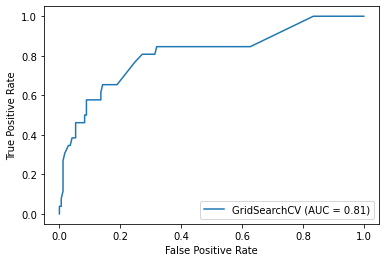

In [9]:
lr_params = {
    'C': (0.001,0.01,0.1,1,10,100),
    'penalty': ('l1', 'l2'),
}

gslr = GridSearchCV(LogisticRegression(random_state=42, solver='liblinear'), lr_params)
gslr.fit(X_train, y_train)

# Score the grid search model with the testing data
lr_acc = gslr.score(X_test, y_test)

print('Best parameters: %r' % gslr.best_params_ )
print('Accuracy: %.3f' % lr_acc)
plot_roc_curve(gslr,X_test,y_test);

## KNN Classifier

[[169   0]
 [ 25   1]]
Best parameters: {'metric': 'manhattan', 'n_neighbors': 11, 'weights': 'distance'}
Accuracy: 0.872


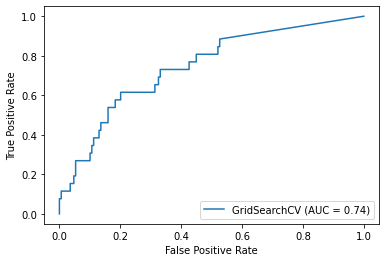

In [10]:
from sklearn.neighbors import KNeighborsClassifier
# Apply KNN model to training data:

knn_params = {
    'n_neighbors': [3,5,11,13,19],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean','manhattan']
}

gsknn = GridSearchCV(KNeighborsClassifier(),knn_params)

#knn = KNeighborsClassifier(p=2,weights='distance',n_neighbors=10)
gsknn.fit(X_train,y_train)

# Predict using model:

y_predict_knn=gsknn.predict(X_test)

#Confusion matrix:

cnf_matrix = confusion_matrix(y_test, y_predict_knn)
print(cnf_matrix)
accuracy_knn=gsknn.score(X_test,y_test)

print('Best parameters: %r' %gsknn.best_params_)
print('Accuracy: %.3f' % accuracy_knn)
plot_roc_curve(gsknn,X_test,y_test);

## Random Forest

[[168   1]
 [ 24   2]]
Best parameters: {'class_weight': 'balanced', 'criterion': 'entropy', 'max_features': 'auto', 'n_estimators': 140}
Accuracy: 0.872


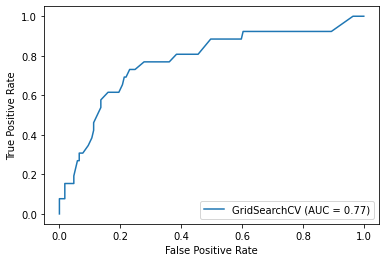

In [11]:
from sklearn.ensemble import RandomForestClassifier

#Apply RF to the training data:

rf_params = {
    'n_estimators' : [100, 120, 140],
    'criterion': ['gini', 'entropy'],
    'max_features': ['auto', 'sqrt', 'log2'],
    'class_weight': ['balanced', 'balanced_subsample']
}

gsrf = GridSearchCV(RandomForestClassifier(),rf_params)

gsrf.fit(X_train,y_train)

# Predict using model:

y_predict_gsrf=gsrf.predict(X_test)

#Confusion matrix:

cnf_matrix = confusion_matrix(y_test, y_predict_gsrf)
print(cnf_matrix)
accuracy_rf=gsrf.score(X_test,y_test)

print('Best parameters: %r' %gsrf.best_params_)
print('Accuracy: %.3f' % accuracy_rf)
plot_roc_curve(gsrf,X_test,y_test);

## Gradient Boosting

[[159  10]
 [ 17   9]]
0.8615384615384616


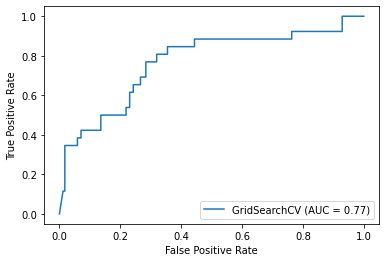

In [13]:
from sklearn.ensemble import GradientBoostingClassifier

gb_params = {
    'n_estimators':[5,50,250,500],
    'max_depth':[1,3,5,7,9],
    'learning_rate':[0.01,0.1,1,10,100]
}

gsgb = GridSearchCV(GradientBoostingClassifier(), gb_params)
gsgb.fit(X_train, y_train)

#Predict using the model:

y_predict_gsgb = gsgb.predict(X_test)

#Confusion matrix:

cnf_matrix = confusion_matrix(y_test, y_predict_gsgb)
print(cnf_matrix)
accuracy_gsgb=gsgb.score(X_test,y_test)
print(accuracy_gsgb)
knn_disp= plot_roc_curve(gsgb,X_test,y_test)

## With Oversampling

In [14]:
from imblearn.over_sampling import RandomOverSampler

oversample = RandomOverSampler(sampling_strategy='minority')
X, y = oversample.fit_resample(X, y)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
print(y.value_counts())

1.0    549
0.0    549
Name: not_sufficient, dtype: int64


[[127  48]
 [  0 155]]
Best parameters: {'metric': 'manhattan', 'n_neighbors': 11, 'weights': 'distance'}
Accuracy: 0.855


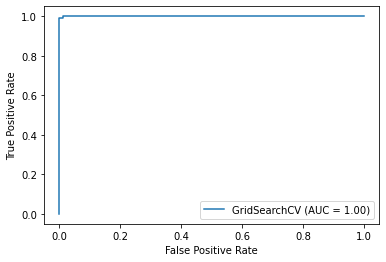

In [15]:
#knn = KNeighborsClassifier(p=2,weights='distance',n_neighbors=10)
gsknn.fit(X_train,y_train)

# Predict using model:

y_predict_knn=gsknn.predict(X_test)

#Confusion matrix:

cnf_matrix = confusion_matrix(y_test, y_predict_knn)
print(cnf_matrix)
accuracy_knn=gsknn.score(X_test,y_test)

print('Best parameters: %r' %gsknn.best_params_)
print('Accuracy: %.3f' % accuracy_knn)
plot_roc_curve(gsknn,X_test,y_test);

[[160  15]
 [  1 154]]
0.9515151515151515


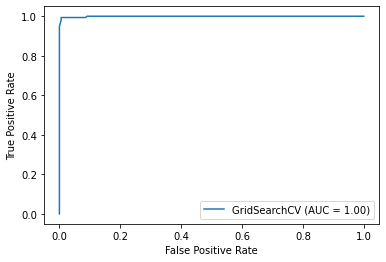

In [16]:
gsrf.fit(X_train, y_train)

#Predict using the model:

y_predict_gsrf = gsrf.predict(X_test)

#Confusion matrix:

cnf_matrix = confusion_matrix(y_test, y_predict_gsrf)
print(cnf_matrix)
Accuracy_gsrf=gsrf.score(X_test,y_test)
print(Accuracy_gsrf)
knn_disp= plot_roc_curve(gsrf,X_test,y_test)

[[167   8]
 [  1 154]]
0.9727272727272728


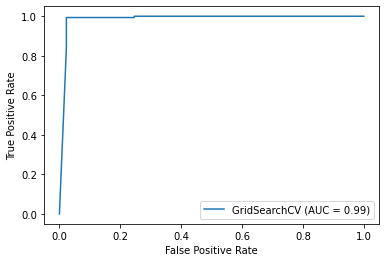

In [17]:
gsgb.fit(X_train, y_train)

#Predict using the model:

y_predict_gsgb = gsgb.predict(X_test)

#Confusion matrix:

cnf_matrix = confusion_matrix(y_test, y_predict_gsgb)
print(cnf_matrix)
Accuracy_gsgb=gsgb.score(X_test,y_test)
print(Accuracy_gsgb)
knn_disp= plot_roc_curve(gsgb,X_test,y_test)